Import libraries

In [10]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.lines import Line2D
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [11]:
# ==========================================
#             USER CONFIGURATION
# ==========================================

# 1. Directory Paths
TRAIN_VAL_PATH = "/home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/datasets/NR_and_WR_split_on_skiers/train_val"
TEST_PATH      = "/home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/datasets/NR_and_WR_split_on_skiers/test"

FILE_FILTER = "NR"

# 2. Raw Input Columns (Must exist in the CSV files)
INPUT_COLS = [
    'speed_kmph', 'power_w', 'frequency_ppm', 
    'thrust_left_ms', 'thrust_right_ms', 
    'impulse_left_ns', 'impulse_right_ns', 
    'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 
    'ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts'
]

# 3. Output Label
LABEL_COL = "Gear"

# 4. Data Processing
SEQ_LEN = 5
STEP = 1
TRANSITION_WINDOW = 3 

# 5. Model Config
HIDDEN_DIM = 32
NUM_LAYERS = 3
DROPOUT = 0.2
BATCH_SIZE = 64
LEARNING_RATE = 0.00005
EPOCHS = 120

In [12]:
# --- HELPER FUNCTIONS ---
def normalize_label(val: object) -> str:
    s = str(val).strip()
    m = re.search(r'^-?\d+(?:\.\d+)?', s)
    if m:
        return f"{float(m.group(0)):.1f}"
    return s

def add_incline_feature(df):
    """Calculates smoothed incline from Altitude."""
    if 'ns1:AltitudeMeters' not in df.columns:
        df['incline'] = 0.0
        return df
    
    # Sort by time if available
    if 'tt_s' in df.columns:
        df = df.sort_values(by='tt_s').reset_index(drop=True)
        
    # 1. Smooth altitude (rolling mean) to remove sensor jitter
    smooth_alt = df['ns1:AltitudeMeters'].rolling(window=5, center=True, min_periods=1).mean()
    
    # 2. Calculate incline (derivative of smoothed altitude)
    df['incline'] = smooth_alt.diff().fillna(0)
    
    return df

def filter_unstable_gears(df, label_col, window_size):
    if df.empty: return df
    gear_changes = df[label_col].ne(df[label_col].shift(1))
    change_points = df[gear_changes].index.tolist()
    remove_indices = set()
    for idx in change_points:
        for i in range(idx - window_size, idx + window_size):
            remove_indices.add(i)
    return df.drop(index=list(remove_indices), errors='ignore')

def make_sure_numeric(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def load_dataset_from_directory(folder_path, file_filter):
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Path not found: {folder_path}")
        
    loaded_data = {}
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    files_to_load = [f for f in all_files if file_filter in f] if file_filter else all_files
    print(f"Loading {len(files_to_load)} files from: {folder_path}...")

    for file in files_to_load:
        full_path = os.path.join(folder_path, file)
        df = pd.read_csv(full_path)
        
        # 1. Clean RAW columns
        df = make_sure_numeric(df, INPUT_COLS)
        
        # 2. Feature Engineering (Incline only)
        df = add_incline_feature(df)
        
        # 3. Check quality
        if df[INPUT_COLS].isna().all().any():
            print(f"  [Skipping] {file}: Empty features.")
            continue

        if LABEL_COL in df.columns:
            df[LABEL_COL] = df[LABEL_COL].apply(normalize_label)
        
        loaded_data[file] = df
    return loaded_data

In [13]:
# --- 1. Load Data (Using raw INPUT_COLS) ---
train_val_dict = load_dataset_from_directory(TRAIN_VAL_PATH, FILE_FILTER)
test_dict = load_dataset_from_directory(TEST_PATH, FILE_FILTER)

# --- 2. Split ---
train_val_keys = list(train_val_dict.keys())
train_keys, val_keys = train_test_split(train_val_keys, test_size=0.2, random_state=42)

# --- 3. Concatenate ---
train_df = pd.concat([train_val_dict[k] for k in train_keys], ignore_index=True)
val_df = pd.concat([train_val_dict[k] for k in val_keys], ignore_index=True)
test_df = pd.concat(test_dict.values(), ignore_index=True) if test_dict else pd.DataFrame()

# =========================================================
# [!!!] UPDATE FEATURE LIST FOR MODELING [!!!]
# We remove Altitude (raw sensor) and add Incline (engineered feature)
# =========================================================

# 1. Start with copy of raw inputs
MODEL_COLS = INPUT_COLS.copy()

# 2. Remove Altitude
if 'ns1:AltitudeMeters' in MODEL_COLS:
    MODEL_COLS.remove('ns1:AltitudeMeters')

# 3. Add Incline (No Ratios)
if 'incline' in train_df.columns:
    MODEL_COLS.append('incline')

# Update INPUT_COLS variable so the rest of the script uses the new list automatically
INPUT_COLS = MODEL_COLS 
print(f"\nUpdated Input Features ({len(INPUT_COLS)}): {INPUT_COLS}")

# --- 4. Filtering & Cleanup ---
if TRANSITION_WINDOW > 0:
    print(f"Filtering unstable transitions (window={TRANSITION_WINDOW})...")
    train_df = filter_unstable_gears(train_df, LABEL_COL, TRANSITION_WINDOW)
    val_df = filter_unstable_gears(val_df, LABEL_COL, TRANSITION_WINDOW)

# Final NaN cleanup using the NEW feature list
train_df = train_df.dropna(subset=INPUT_COLS + [LABEL_COL])
val_df = val_df.dropna(subset=INPUT_COLS + [LABEL_COL])
test_df = test_df.dropna(subset=INPUT_COLS + [LABEL_COL])

print(f"Final Rows -> Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# --- 5. Fit Encoder & Scaler ---
all_labels = sorted(pd.concat([train_df[LABEL_COL], val_df[LABEL_COL], test_df[LABEL_COL]]).unique())
encoder = LabelEncoder()
encoder.fit(all_labels)

scaler = StandardScaler()
scaler.fit(train_df[INPUT_COLS])
print("Scaler fitted on new feature set.")

Loading 10 files from: /home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/datasets/NR_and_WR_split_on_skiers/train_val...
Loading 2 files from: /home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/datasets/NR_and_WR_split_on_skiers/test...

Updated Input Features (14): ['speed_kmph', 'power_w', 'frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts', 'incline']
Filtering unstable transitions (window=3)...
Final Rows -> Train: 7287 | Val: 1574 | Test: 2419
Scaler fitted on new feature set.


In [14]:
def prepare_dataset(df):
    X_vals = df[INPUT_COLS].values
    y_vals = encoder.transform(df[LABEL_COL].values)
    
    # Scale features
    X_vals = scaler.transform(X_vals)
    
    # Convert to Tensors
    X_t = torch.tensor(X_vals, dtype=torch.float32)
    y_t = torch.tensor(y_vals, dtype=torch.long)
    
    return X_t, y_t

print("Building tensors...")
X_train, y_train = prepare_dataset(train_df)
X_val, y_val = prepare_dataset(val_df)
X_test, y_test = prepare_dataset(test_df)

print(f"Train shape: {X_train.shape}")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

Building tensors...
Train shape: torch.Size([7287, 14])
Val shape:   torch.Size([1574, 14])
Test shape:  torch.Size([2419, 14])


/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [15]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, dropout=0.2):
        super(MLP, self).__init__()
        
        # 3 Hidden Layers (as per your previous config)
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

# Compute class weights for imbalance
class_counts = torch.bincount(y_train)
class_weights = 1.0 / class_counts.float().clamp_min(1.0)
class_weights = class_weights * (len(class_counts) / class_weights.sum())
class_weights = class_weights.to(device)

print("Class Weights:", class_weights)

# Initialize Model
model = MLP(
    in_dim=len(INPUT_COLS),
    out_dim=len(encoder.classes_),
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Class Weights: tensor([0.6582, 0.8437, 0.2123, 2.2858])


Starting training...
Epoch [10/120] Train Loss: 1.0304 | Val Loss: 1.0625 | Val Acc: 33.74%
Epoch [20/120] Train Loss: 0.8241 | Val Loss: 0.8056 | Val Acc: 72.24%
Epoch [30/120] Train Loss: 0.7048 | Val Loss: 0.6774 | Val Acc: 76.75%
Epoch [40/120] Train Loss: 0.6533 | Val Loss: 0.6393 | Val Acc: 78.40%
Epoch [50/120] Train Loss: 0.6083 | Val Loss: 0.6214 | Val Acc: 80.69%
Epoch [60/120] Train Loss: 0.5887 | Val Loss: 0.6109 | Val Acc: 82.21%
Epoch [70/120] Train Loss: 0.5615 | Val Loss: 0.5968 | Val Acc: 82.91%
Epoch [80/120] Train Loss: 0.5569 | Val Loss: 0.5977 | Val Acc: 83.23%
Epoch [90/120] Train Loss: 0.5442 | Val Loss: 0.5872 | Val Acc: 83.55%
Epoch [100/120] Train Loss: 0.5231 | Val Loss: 0.6026 | Val Acc: 83.67%
Epoch [110/120] Train Loss: 0.5065 | Val Loss: 0.5907 | Val Acc: 83.86%
Epoch [120/120] Train Loss: 0.5035 | Val Loss: 0.5904 | Val Acc: 84.18%

Restoring best model (Val Loss: 0.5855)


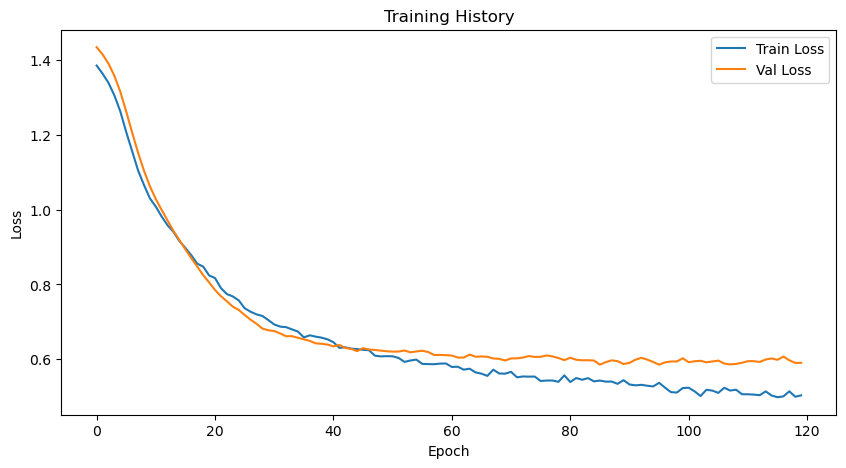

In [16]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None

print("Starting training...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct / total

    # Save Best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# Load Best Model
if best_model_state:
    print(f"\nRestoring best model (Val Loss: {best_val_loss:.4f})")
    model.load_state_dict(best_model_state)

# Plot
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


--- Test Set Classification Report ---
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.79       391
         2.0       0.86      0.82      0.84       366
         3.0       0.91      0.82      0.86      1431
         4.0       0.41      0.73      0.53       231

    accuracy                           0.80      2419
   macro avg       0.75      0.79      0.76      2419
weighted avg       0.84      0.80      0.82      2419



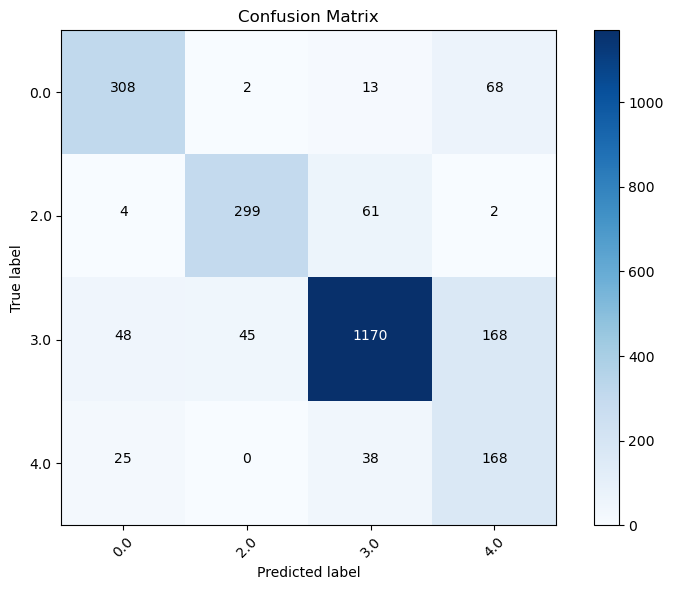

In [17]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

# Evaluation Metrics
print("\n--- Test Set Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=encoder.classes_, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(encoder.classes_))
plt.xticks(tick_marks, encoder.classes_, rotation=45)
plt.yticks(tick_marks, encoder.classes_)

# Label the squares
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

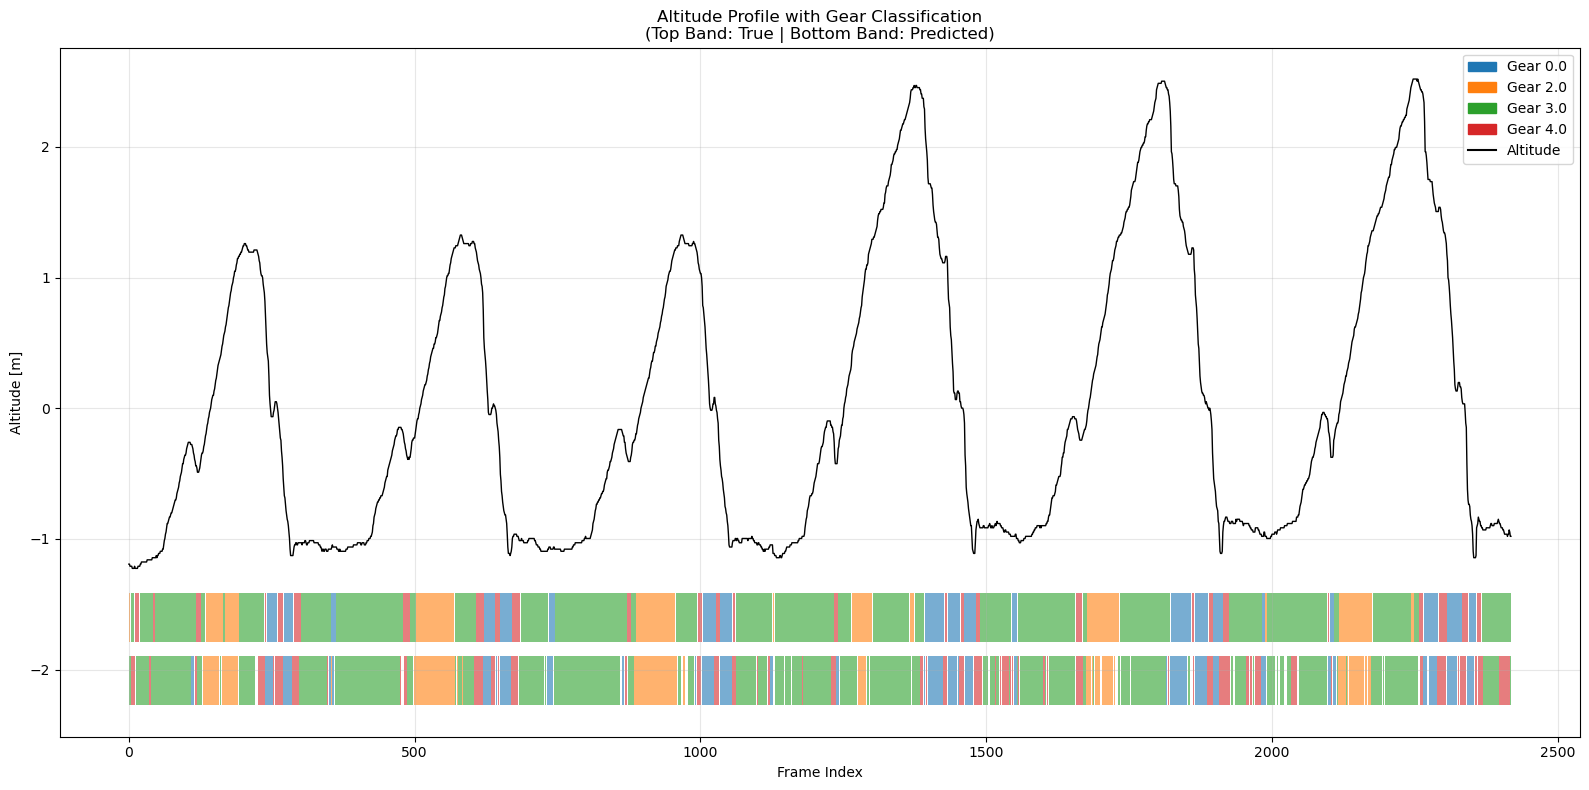

In [18]:
# ==========================================
# ALTITUDE vs TIME + TRUE/PRED GEAR BANDS
# ==========================================

# 1. Align Data
# Since MLP is frame-by-frame (no sequence offset), indices match exactly.
# We just need to handle the case where 'Time' might be missing.

time_col = 'Time' if 'Time' in test_df.columns else None
if time_col:
    t = test_df[time_col].values
else:
    print("Warning: 'Time' column not found. Using DataFrame index.")
    t = test_df.index.values

# Altitude
alt = test_df['ns1:AltitudeMeters'].values

# Predictions and True Labels
pred_int = np.array(all_preds)
true_int = np.array(all_labels)

# Ensure all arrays are the exact same length (just a safety check)
min_len = min(len(t), len(alt), len(pred_int), len(true_int))
t = t[:min_len]
alt = alt[:min_len]
pred_int = pred_int[:min_len]
true_int = true_int[:min_len]

# 2. Decode Labels (Integers -> Original Strings)
pred_str = encoder.inverse_transform(pred_int)
true_str = encoder.inverse_transform(true_int)
unique_classes_str = encoder.classes_

# 3. Setup Colors
# Assign a unique color to each class for consistency
cmap = plt.get_cmap("tab10")
class_to_color = {cls_name: cmap(i) for i, cls_name in enumerate(unique_classes_str)}

# 4. Plotting
plt.figure(figsize=(16, 8))

# A. Plot Altitude
plt.plot(t, alt, color='black', linewidth=1, label="Altitude", zorder=10)

# Calculate dynamic y-positions for the bands based on altitude range
y_min, y_max = alt.min(), alt.max()
y_range = y_max - y_min
if y_range == 0: y_range = 10  # Prevent division by zero if flat

# Band positions (placed slightly below the minimum altitude)
true_band_top = y_min - (0.05 * y_range)
true_band_bot = y_min - (0.15 * y_range)
pred_band_top = y_min - (0.18 * y_range)
pred_band_bot = y_min - (0.28 * y_range)

# B. Plot TRUE Gear Band
for cls_name in unique_classes_str:
    mask = (true_str == cls_name)
    if np.any(mask):
        plt.fill_between(
            t, true_band_bot, true_band_top,
            where=mask,
            color=class_to_color[cls_name],
            alpha=0.6,
            step='mid',  # 'mid' ensures sharp transitions for discrete data
            linewidth=0
        )

# C. Plot PREDICTED Gear Band
for cls_name in unique_classes_str:
    mask = (pred_str == cls_name)
    if np.any(mask):
        plt.fill_between(
            t, pred_band_bot, pred_band_top,
            where=mask,
            color=class_to_color[cls_name],
            alpha=0.6,
            step='mid',
            linewidth=0
        )

# D. Formatting & Legend
plt.xlabel("Time" if time_col else "Frame Index")
plt.ylabel("Altitude [m]")
plt.title("Altitude Profile with Gear Classification\n(Top Band: True | Bottom Band: Predicted)")

# Create custom legend handles
handles = [mpatches.Patch(color=class_to_color[c], label=f"Gear {c}") for c in unique_classes_str]
handles.append(plt.Line2D([], [], color='black', label='Altitude'))

plt.legend(handles=handles, loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()